In [1]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import decimate
import matplotlib.pyplot as plt
import torch

def get_label(filename):
    if "__" in filename:
        return filename.split('__')[0]
    elif "_noisy" in filename:
        return filename.split('_noisy')[0] + "_noisy"
    else:
        return "other"

def process_audio_file(directory, filename, new_sample_rate,min_duration):
    try:
        # Load the audio file
        sample_rate, audio_data = wavfile.read(os.path.join(directory, filename))
        
        # If the duration is longer than 4 seconds
        if len(audio_data)/sample_rate > min_duration/new_sample_rate:
            # Calculate the downsampling factor
            downsample_factor = sample_rate // new_sample_rate
            
            # Downsample the audio data
            downsampled_audio_data = decimate(audio_data, downsample_factor)
            
            # Convert the downsampled audio data to a 1D tensor
            return downsampled_audio_data
        else:
            #print(f'Skipping {filename} because it is shorter than 4 seconds.')
            return None
    except Exception as e:
        print(f'Error processing {filename}: {str(e)}')
        return None

def process_directory(directory, new_sample_rate, data_length):
    # List all .wav files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    
    # Initialize empty lists to store the data and labels
    data = []
    labels = []
    
    # Process each file
    for filename in files:
        audio_data = process_audio_file(directory, filename, new_sample_rate, data_length)
        if audio_data is not None:
            # If the audio_data is longer than data_length, split it into multiple chunks
            for i in range(0, len(audio_data), data_length):
                chunk = audio_data[i:i+data_length]
                # Only add chunks that have the required length
                if len(chunk) == data_length:
                    data.append(chunk)
                    labels.append(get_label(filename))
    
    # Convert the data and labels lists to 2D and 1D tensors, respectively
    data_tensor = torch.tensor(data)
    labels_arr = np.array(labels)
    
    return data_tensor, labels_arr



In [2]:
def rescale_data(data, max_Bt):
    # Create an empty list to store the rescaled data
    rescaled_data = []

    # For each signal in the data
    for signal in data:
        # Compute the maximum value of the signal
        max_value = torch.max(torch.abs(signal))

        # Rescale the signal so that its maximum value is max_Bt
        rescaled_signal = signal * max_Bt / max_value

        # Add the rescaled signal to the list
        rescaled_data.append(rescaled_signal)

    # Convert the list of rescaled signals into a 2D tensor
    rescaled_data_tensor = torch.stack(rescaled_data)

    return rescaled_data_tensor


In [11]:
directory = "/home/ss2722/Desktop/Big_Big_Project/testing_data_sets/Dangerous-Heartbeat-Dataset-(DHD)/audio/"
new_sample_rate =800
data_length = 2000
data_tensor,labels_arr=process_directory(directory, new_sample_rate,data_length)

In [12]:
import torch.nn.functional as F

padding=1000

data_tensor = F.pad(data_tensor, (0, padding))
data_tensor = rescale_data(data_tensor, 1)

Data tensor shape: torch.Size([1305, 3000])
Labels tensor shape: (1305,)
artifact: 120
extrahls: 43
extrastole: 85
murmur: 264
murmur_noisy: 81
normal: 329
normal_noisy: 383


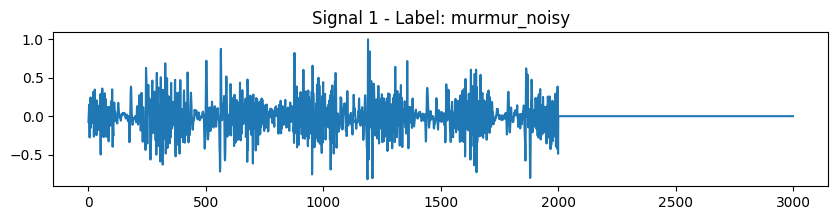

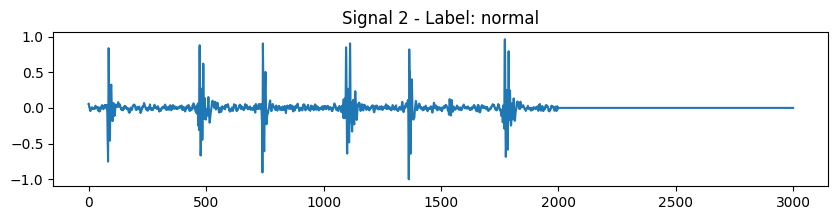

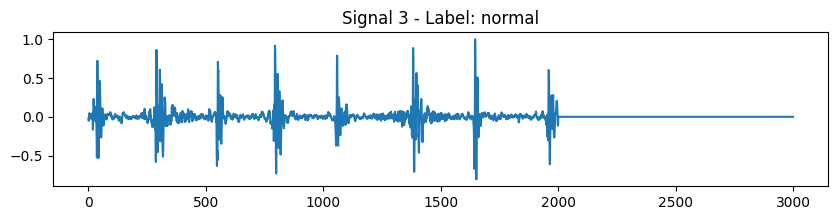

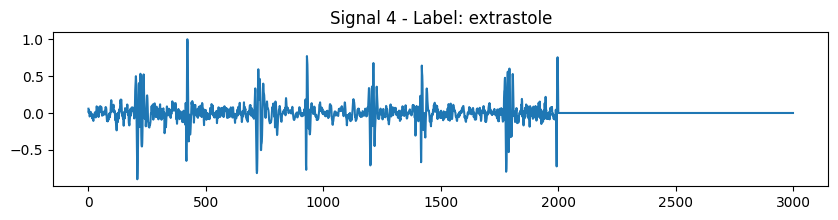

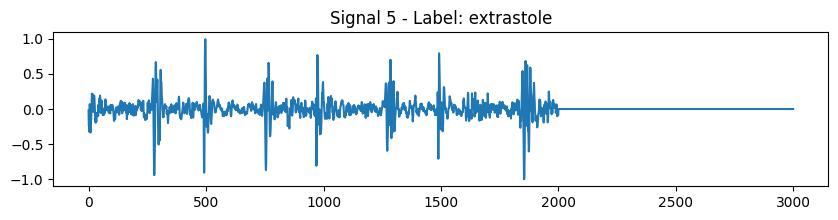

In [13]:
# Check the data and labels tensors
print(f"Data tensor shape: {data_tensor.shape}")
print(f"Labels tensor shape: {labels_arr.shape}")

# Print the counts for each label
unique_labels, counts = np.unique(labels_arr, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f'{label}: {count}')

# Plot the first 5 signals
for i, signal in enumerate(data_tensor[:5]):
    plt.figure(figsize=(10, 2))
    plt.plot(signal)
    plt.title(f"Signal {i+1} - Label: {labels_arr[i]}")
    plt.show()

In [63]:
# # Plot the first 5 signals
# for i, signal in enumerate(data_tensor[:5]):
#     plt.figure(figsize=(10, 2))
#     plt.plot(signal)
#     plt.title(f"Signal {i+1} - Label: {labels_arr[i]}")
#     plt.show()

In [14]:
# Create a boolean mask where True indicates that the label does not contain 'noisy'

#mask = np.array([('noisy' not in label) and ('extrahls' not in label)and ('artifact' not in label)and ('extrastole' not in label) for label in labels_arr])
mask = np.array([('noisy' not in label) and ('murmur' not in label)and ('artifact' not in label)and ('extrastole' not in label) for label in labels_arr])
#mask = np.array([('noisy' not in label) and ('extrahls' not in label) for label in labels_arr])

# Apply the mask to the data and labels tensors
data_tensor = data_tensor[mask]
labels_arr = labels_arr[mask]

# Check the data and labels tensors
print(f"Data tensor shape: {data_tensor.shape}")
print(f"Labels tensor shape: {labels_arr.shape}")
# Get the unique labels and their counts
unique_labels, counts = np.unique(labels_arr, return_counts=True)
# Print the counts for each label
for label, count in zip(unique_labels, counts):
    print(f'{label}: {count}')

Data tensor shape: torch.Size([372, 3000])
Labels tensor shape: (372,)
extrahls: 43
normal: 329


In [15]:
# Define a dictionary to map labels to numbers
label_dict = {
    'normal': 0,
    'murmur':999,
    'extrastole': 999,
    'artifact':999,
    'extrahls':1
}

# Convert labels to numbers using the dictionary
labels_arr = [label_dict[label] if label in label_dict else 0 for label in labels_arr]

In [16]:
data_tensor = data_tensor.unsqueeze(-1)
labels_tensor = torch.LongTensor(labels_arr)

In [67]:
#down sample the data labels

In [17]:
# Assuming 'normal' is represented as 0 and 'extrahls' as 1
extrahls_indices = (labels_tensor == 1).nonzero(as_tuple=True)[0]  # reshaping to 1D
normal_indices = (labels_tensor == 0).nonzero(as_tuple=True)[0]

# Set a random seed for reproducibility
torch.manual_seed(0)

# Randomly undersample 'normal' indices
undersampled_normal_indices = normal_indices[torch.multinomial(torch.ones_like(normal_indices, dtype=torch.float), num_samples=min(len(normal_indices),len(extrahls_indices)), replacement=False)]


# Combine the indices
balanced_indices = torch.cat((extrahls_indices, undersampled_normal_indices))

# Get the balanced dataset
balanced_data = data_tensor[balanced_indices]
balanced_labels = labels_tensor[balanced_indices]


Data tensor shape: torch.Size([86, 3000, 1])
Labels tensor shape: torch.Size([86])
0: 43
1: 43


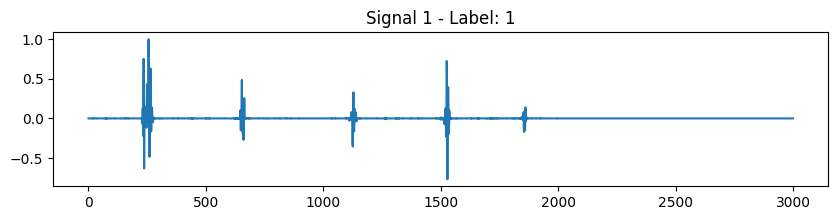

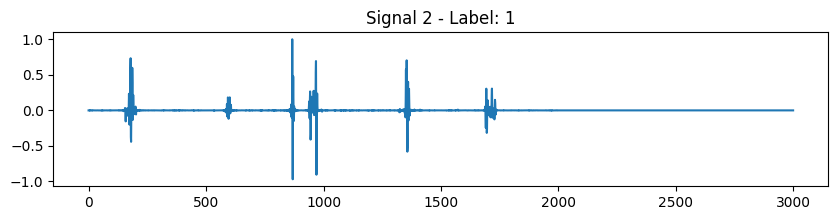

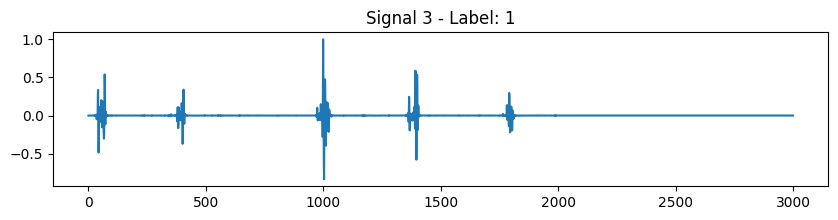

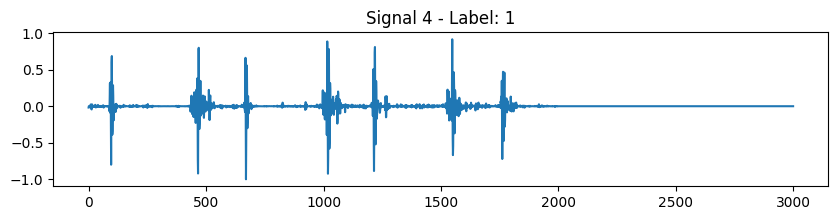

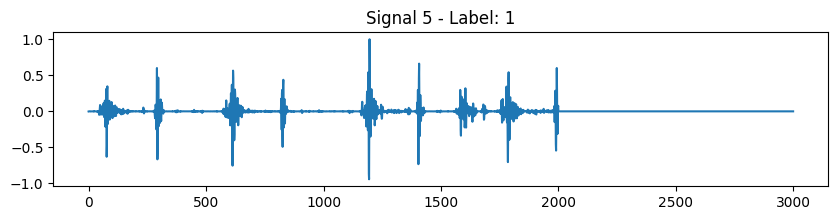

In [19]:
# Check the balanced data and labels tensors
print(f"Data tensor shape: {balanced_data.shape}")
print(f"Labels tensor shape: {balanced_labels.shape}")

# Convert tensor to numpy for using np.unique
balanced_labels_np = balanced_labels.numpy()

# Print the counts for each label
unique_labels, counts = np.unique(balanced_labels_np, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f'{label}: {count}')

# Plot the first 5 signals
for i, signal in enumerate(balanced_data[:5]):
    plt.figure(figsize=(10, 2))
    plt.plot(signal)
    plt.title(f"Signal {i+1} - Label: {balanced_labels_np[i]}")
    plt.show()


In [74]:
torch.save({'data': balanced_data, 'labels': balanced_labels}, 'DHD_2x37_normal-extrahls_3k+1k.pt')